In [1]:
import glob
import natsort
general_path = '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/'
ob1_files = glob.glob(general_path+'./LabelDataObstetrics1/*.mat')
ob1_files = natsort.natsorted(ob1_files)
#split ob1_files.split('/')
patient_t=[]
sweep_t=[]
for i in range(len(ob1_files)):
    ob1_files[i]=ob1_files[i].split('/')[-1].split('.')[0]
    patient=ob1_files[i].split('_')[0]
    sweep=ob1_files[i].split('sweep')[1]
    #if sweep[0] is not a number, use sweep[1]
    sweep = sweep[1] if not sweep[0].isdigit() else sweep[0]
    patient_t.append(patient)
    sweep_t.append(sweep)
print(ob1_files)
print(patient_t)
print(sweep_t)

['001_sweep1', '001_sweep2', '001_sweep3', '001_sweep4', '001_sweep5', '002_sweep1', '002_sweep2', '002_sweep3', '002_sweep5', '002_sweep6', '003_sweep1', '003_sweep2', '003_sweep3', '003_sweep4', '004_sweep1', '004_sweep2', '004_sweep4', '004_sweep5', '004_sweep6', '004_sweep7', '004_sweep8', '005_sweep1', '005_sweep2', '005_sweep3', '005_sweep4', '005_sweep5', '005_sweep6', '006_sweep1', '006_sweep4', '006_sweep5', '006_sweep6', '006_sweep7', '007_sweep1', '007_sweep2', '007_sweep3', '007_sweep4', '007_sweep6', '007_sweep7', '007_sweep8', '008_sweep1', '008_sweep2', '008_sweep3', '008_sweep6', '008_sweep7', '008_sweep8', '009_sweep1', '009_sweep2', '009_sweep3', '009_sweep4', '009_sweep5', '009_sweep6', '009_sweep7', '010_sweep1', '010_sweep2', '010_sweep3', '010_sweep4', '010_sweep6', '011_sweep1 (1)', '011_sweep1', '011_sweep2 (1)', '011_sweep2', '011_sweep3 (1)', '011_sweep3', '011_sweep4 (1)', '011_sweep4', '011_sweep5 (1)', '011_sweep5', '011_sweep6 (1)', '011_sweep6', '012_swee

In [48]:
import glob
import natsort
general_path = '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/'
ob1_files = glob.glob(general_path+'./LabelDataObstetrics/*.mat')
ob1_files = natsort.natsorted(ob1_files)
#split ob1_files.split('/')
patient_t=[]
sweep_t=[]
for i in range(len(ob1_files)):
    sweep_t.append(ob1_files[i].split('/')[-1].split('.')[0])
    #check if ob1_files[i] has word copy, if so remove it
    if 'copy' in sweep_t[i]:
        sweep_t[i]=sweep_t[i].split(' copy')[0]
    patient=sweep_t[i][0:3]
    #if patient has letter _ in it, remove it and add a 0 start
    patient = '0'+patient if '_' in patient else patient
    patient=patient.split('_')[0]
    patient_t.append(patient)
print(ob1_files)
print(patient_t)
print(sweep_t)

['/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/002_sweep1 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/002_sweep4 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/002_sweep5 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/007_sweep1 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/008_sweep1 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/008_sweep7 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/010_sweep2 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/025_sweep4 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDa

In [20]:
print(len(ob1_files))

117


In [52]:


import numpy as np
import scipy.io as sio
import skvideo.io as skv
import torchio as tio
from skimage.transform import resize
import os
import sys
import matplotlib.pyplot as plt
import skimage.morphology as morph

src_path = os.path.join(general_path, 'src')
sys.path.append(src_path)

#import overlay_video from src/utils/overlay_video.py assuming that the file is in the same directory
from utils.overlay_video import generate_overlay_video


for i in range(0,117):
# for i in range(2,3):
    mp4_file_path = general_path+'./Study/'+patient_t[i]+'/'+sweep_t[i]+'.mp4'
    print(mp4_file_path)
    ob = sio.loadmat(ob1_files[i])['labels']
    ob=np.moveaxis(ob, 2, 0)
    gt_video = skv.vread(mp4_file_path)

    diff = gt_video[1:,:,:,0]-gt_video[:-1,:,:,0]
    
    #remove small objects using morphological operations
    # diff = morph.remove_small_objects(diff.astype(bool), min_size=100)

    diff_sum = np.sum(diff,axis=(1,2))
    #normalize diff_sum
    diff_sum = diff_sum/np.max(diff_sum)

    # Assuming diff_sum is your normalized data array from the plot
    # Example: diff_sum = np.array([...])  # Replace with your actual array
    threshold = 0.2

    # Detect indices where diff_sum crosses above the threshold
    first_frame = np.where(diff_sum > threshold)[0][0]  # First upward crossing
    last_frame = np.where(diff_sum > threshold)[0][-1]  # Last upward crossing (before drop)
    # print(diff.shape)
    # Plot the diff_sum
  
    # Obtener los límites del área de interés
    #if diff[first_frame+50] is zero, remove it, make first_frame+1
    if np.sum(diff[first_frame+50]) == 0:
        first_frame = first_frame+1

    row_limits, col_limits = np.where(morph.remove_small_objects(diff[first_frame+50].astype(bool), min_size=100) > 0)
    y1, y2 = row_limits.min(), row_limits.max()
    x1, x2 = col_limits.min(), col_limits.max()

    # Recortar el área de interés
    gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
    ob = ob[first_frame:last_frame, :,:]
    #print ob frames where is not zero

    # Check shapes between gt_video and ob for width and height, and align them by cropping or padding centered
    if gt_video.shape[1] != ob.shape[1] or gt_video.shape[2] != ob.shape[2]:
        # Calculate padding or cropping for height (dim 1)
        pad_or_crop_h = (gt_video.shape[1] - ob.shape[1])
        pad_h_before = max(0, pad_or_crop_h // 2)
        pad_h_after = max(0, pad_or_crop_h - pad_h_before)
        crop_h_before = max(0, -pad_or_crop_h // 2)
        crop_h_after = max(0, -pad_or_crop_h - crop_h_before)

        # Calculate padding or cropping for width (dim 2)
        pad_or_crop_w = (gt_video.shape[2] - ob.shape[2])
        pad_w_before = max(0, pad_or_crop_w // 2)
        pad_w_after = max(0, pad_or_crop_w - pad_w_before)
        crop_w_before = max(0, -pad_or_crop_w // 2)
        crop_w_after = max(0, -pad_or_crop_w - crop_w_before)

        # Apply padding if needed
        if pad_h_before > 0 or pad_h_after > 0 or pad_w_before > 0 or pad_w_after > 0:
            ob = np.pad(ob, 
                            ((0, 0), 
                            (pad_h_before, pad_h_after), 
                            (pad_w_before, pad_w_after)), 
                            'constant')

        # Apply cropping if needed
        if crop_h_before > 0 or crop_h_after > 0 or crop_w_before > 0 or crop_w_after > 0:
            ob = ob[:, crop_h_before:ob.shape[1] - crop_h_after, crop_w_before:ob.shape[2] - crop_w_after]

    # Now, `ob` will have the same shape as `gt_video`
    # Create a TorchIO subject with paired data
    subject = tio.Subject(
    video_gt=tio.ScalarImage(tensor=np.expand_dims(gt_video,axis=0)),  # Add channel dimension
    label=tio.LabelMap(tensor=np.expand_dims(ob,axis=0))  # Add channel dimension
    )

    #num_classes = 2  # Número de clases
    # Crear la versión one-hot encoded
    #one_hot = np.eye(num_classes)[ob]  # Esto genera el one-hot encoding
    # Verificar el nuevo shape
    # print(one_hot.shape) 
    #generate_overlay_video(gt_video, one_hot, fps=30, output_video=general_path+'data/maddie_vid/'+patient_t[i]+'_sweep'+sweep_t[i]+'_overlay.avi',gt_w=True)
    
    #efine the resize transform
    resize_transform = tio.transforms.Resize((128,128,128))  # New shape: [frames, width, height]

    # Apply the resize transform to the subject
    resized_subject = resize_transform(subject)

    # Extract resized video GT and label from the subject
    resized_video_gt = resized_subject.video_gt.tensor.squeeze(0).numpy()  # Remove channel dimension
    resized_label = resized_subject.label.tensor.squeeze(0).numpy().astype(int)  # Ensure integers for label

    #save the label with ground truth in npz format
    #np.savez_compressed(general_path+'data/'+patient_t[i]+'_sweep'+sweep_t[i]+'.npz', video=resized_video_gt, label=resized_label.astype(np.uint8))
    #save with np.save as npy gt and label
    np.save(general_path+'data/128x128x128_maddie/'+sweep_t[i]+'_gt.npy', resized_video_gt)
    np.save(general_path+'data/128x128x128_maddie/'+sweep_t[i]+'_label.npy', resized_label.astype(np.uint8))

    print(i)

/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/002/002_sweep1.mp4
0
/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/002/002_sweep4.mp4
1
/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/002/002_sweep5.mp4
2
/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/007/007_sweep1.mp4
3
/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/008/008_sweep1.mp4
4
/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/008/008_sweep7.mp4
5
/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/010/010_sweep2.mp4
6
/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/025/025_sweep4.mp4
7
/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/025/025_sweep5.mp4
8
/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/030/030_sweep3.mp4
9
/Users/emilio/Librar

In [27]:
ob1_files = glob.glob(general_path+'./LabelDataObstetrics1/*.mat')
ob1_files = natsort.natsorted(ob1_files)
#split ob1_files.split('/')
ob1_files=[i.split('/')[-1].split('.')[0] for i in ob1_files]
npy_files = glob.glob(general_path+'./data/128x128x128/*.npy')
npy_files = natsort.natsorted(npy_files)
npy_files=list(set([i.split('/')[-1].split('.')[0].split('_gt')[0].split('_label')[0] for i in npy_files]))
print(npy_files)
print(len(ob1_files))
print(len(npy_files))
#find the difference between the two lists
diff = list(set(npy_files) - set(ob1_files))
print(diff)


['011_sweep5', '005_sweep4', '012_sweep4', '011_sweep1', '011_sweep3', '002_sweep5', '014_sweep3', '001_sweep5', '005_sweep2', '004_sweep1', '003_sweep2', '013_sweep1', '009_sweep3', '012_sweep1', '014_sweep2', '014_sweep5', '016_sweep4', '013_sweep3', '006_sweep1', '016_sweep6', '014_sweep6', '012_sweep6', '002_sweep6', '015_sweep1', '004_sweep6', '014_sweep1', '003_sweep1', '008_sweep1', '006_sweep7', '004_sweep8', '008_sweep3', '011_sweep4', '006_sweep6', '010_sweep1', '005_sweep1', '007_sweep7', '013_sweep5', '009_sweep4', '002_sweep3', '015_sweep4', '001_sweep3', '011_sweep2', '005_sweep3', '005_sweep6', '007_sweep4', '009_sweep5', '006_sweep4', '012_sweep7', '011_sweep6', '003_sweep4', '013_sweep6', '007_sweep8', '015_sweep2', '014_sweep8', '014_sweep7', '008_sweep2', '016_sweep7', '009_sweep6', '004_sweep4', '015_sweep5', '002_sweep1', '008_sweep6', '004_sweep2', '012_sweep3', '007_sweep2', '004_sweep5', '012_sweep2', '009_sweep7', '004_sweep7', '001_sweep1', '005_sweep5', '008_

/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/001/001_sweep3.mp4
(467, 1044, 1221)
(467, 1052, 1220)
116
583


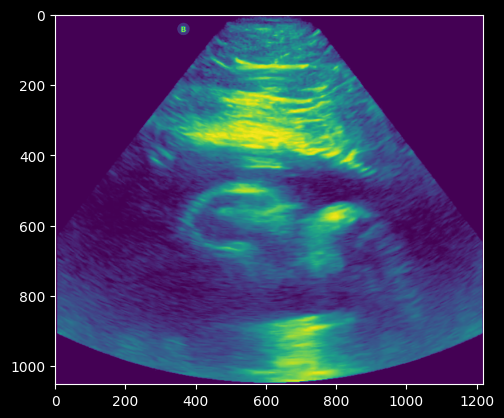

In [8]:


import numpy as np
import scipy.io as sio
import skvideo.io as skv
import torchio as tio
from skimage.transform import resize
import os
import sys
import matplotlib.pyplot as plt
import skimage.morphology as morph

src_path = os.path.join(general_path, 'src')
sys.path.append(src_path)

#import overlay_video from src/utils/overlay_video.py assuming that the file is in the same directory
from utils.overlay_video import generate_overlay_video

ob1_files = glob.glob(general_path+'./LabelDataObstetrics1/*.mat')
ob1_files = natsort.natsorted(ob1_files)

for i in range(2,3):
# for i in range(2,3):
     mp4_file_path = general_path+'./Study/'+patient_t[i]+'/'+patient_t[i]+'_sweep'+sweep_t[i]+'.mp4'
     print(mp4_file_path)
     ob = sio.loadmat(ob1_files[i])['labels']
     ob=np.moveaxis(ob, 2, 0)
     gt_video = skv.vread(mp4_file_path)
     diff = gt_video[1:,:,:,0]-gt_video[:-1,:,:,0]
     #remove small objects using morphological operations
     # diff = morph.remove_small_objects(diff.astype(bool), min_size=100)

     diff_sum = np.sum(diff,axis=(1,2))
     #normalize diff_sum
     diff_sum = diff_sum/np.max(diff_sum)

     # Assuming diff_sum is your normalized data array from the plot
     # Example: diff_sum = np.array([...])  # Replace with your actual array
     threshold = 0.2

     # Detect indices where diff_sum crosses above the threshold
     first_frame = np.where(diff_sum > threshold)[0][0]  # First upward crossing
     last_frame = np.where(diff_sum > threshold)[0][-1]  # Last upward crossing (before drop)
     # print(diff.shape)

     # Obtener los límites del área de interés
     row_limits, col_limits = np.where(morph.remove_small_objects(diff[first_frame+50].astype(bool), min_size=100) > 0)
     y1, y2 = row_limits.min(), row_limits.max()
     x1, x2 = col_limits.min(), col_limits.max()
     x1=271
     x2=1491
     y1=28
     y2=1080

     # Recortar el área de interés
     gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
     ob = ob[first_frame:last_frame, :,:]

     plt.figure()
     plt.imshow(gt_video[430])
     print(ob.shape)
     print(gt_video.shape)
     #print ob frames where is not zero
     print(first_frame)
     print(last_frame)
     break

     # Check shapes between gt_video and ob for width and height, and align them by cropping or padding centered
     if gt_video.shape[1] != ob.shape[1] or gt_video.shape[2] != ob.shape[2]:
          # Calculate padding or cropping for height (dim 1)
          pad_or_crop_h = (gt_video.shape[1] - ob.shape[1])
          pad_h_before = max(0, pad_or_crop_h // 2)
          pad_h_after = max(0, pad_or_crop_h - pad_h_before)
          crop_h_before = max(0, -pad_or_crop_h // 2)
          crop_h_after = max(0, -pad_or_crop_h - crop_h_before)

          # Calculate padding or cropping for width (dim 2)
          pad_or_crop_w = (gt_video.shape[2] - ob.shape[2])
          pad_w_before = max(0, pad_or_crop_w // 2)
          pad_w_after = max(0, pad_or_crop_w - pad_w_before)
          crop_w_before = max(0, -pad_or_crop_w // 2)
          crop_w_after = max(0, -pad_or_crop_w - crop_w_before)

          # Apply padding if needed
          if pad_h_before > 0 or pad_h_after > 0 or pad_w_before > 0 or pad_w_after > 0:
               ob = np.pad(ob, 
                              ((0, 0), 
                              (pad_h_before, pad_h_after), 
                              (pad_w_before, pad_w_after)), 
                              'constant')

          # Apply cropping if needed
          if crop_h_before > 0 or crop_h_after > 0 or crop_w_before > 0 or crop_w_after > 0:
               ob = ob[:, crop_h_before:ob.shape[1] - crop_h_after, crop_w_before:ob.shape[2] - crop_w_after]

     # Now, `ob` will have the same shape as `gt_video`
     # Create a TorchIO subject with paired data
     subject = tio.Subject(
     video_gt=tio.ScalarImage(tensor=np.expand_dims(gt_video,axis=0)),  # Add channel dimension
     label=tio.LabelMap(tensor=np.expand_dims(ob,axis=0))  # Add channel dimension
     )

     #efine the resize transform
     resize_transform = tio.transforms.Resize((128,128,128))  # New shape: [frames, width, height]

     # Apply the resize transform to the subject
     resized_subject = resize_transform(subject)

     # Extract resized video GT and label from the subject
     resized_video_gt = resized_subject.video_gt.tensor.squeeze(0).numpy()  # Remove channel dimension
     resized_label = resized_subject.label.tensor.squeeze(0).numpy().astype(int)  # Ensure integers for label

     num_classes = 6  # Número de clases
     # Crear la versión one-hot encoded
     one_hot = np.eye(num_classes)[resized_label]  # Esto genera el one-hot encoding
     # Verificar el nuevo shape
     # print(one_hot.shape) 
     #generate_overlay_video(resized_video_gt, one_hot, fps=30, output_video=general_path+'data/128x128x128'+patient_t[i]+'_sweep'+sweep_t[i]+'_overlay.avi',gt_w=True)
     #save the label with ground truth in npz format
     #np.savez_compressed(general_path+'data/'+patient_t[i]+'_sweep'+sweep_t[i]+'.npz', video=resized_video_gt, label=resized_label.astype(np.uint8))
     #save with np.save as npy gt and label
     np.save(general_path+'data/128x128x128/'+patient_t[i]+'_sweep'+sweep_t[i]+'_gt.npy', resized_video_gt)
     np.save(general_path+'data/128x128x128/'+patient_t[i]+'_sweep'+sweep_t[i]+'_label.npy', resized_label.astype(np.uint8))

     print(i)

In [9]:
import numpy as np
import scipy.io as sio
import skvideo.io as skv
import torchio as tio
from skimage.transform import resize
import os
import sys
import matplotlib.pyplot as plt
import skimage.morphology as morph

src_path = os.path.join(general_path, 'src')
sys.path.append(src_path)

#import overlay_video from src/utils/overlay_video.py assuming that the file is in the same directory
from utils.overlay_video import generate_overlay_video

ob1_files = glob.glob(general_path+'./LabelDataObstetrics1/*.mat')
ob1_files = natsort.natsorted(ob1_files)
from collections import Counter

# Inicializar contador para las clases
class_counts = Counter()
total_pixels = 0  # Contador total de píxeles

for i in range(len(ob1_files)):  # Iterar sobre todos los videos
#for i in range(81,82):
    mp4_file_path = general_path + './Study/' + patient_t[i] + '/' + patient_t[i] + '_sweep' + sweep_t[i] + '.mp4'
    print(f"Procesando: {mp4_file_path}")
    
    # Cargar etiquetas y video
    ob = sio.loadmat(ob1_files[i])['labels']
    ob = np.moveaxis(ob, 2, 0)
    gt_video = skv.vread(mp4_file_path)
    
    # Calcular diferencias de frames y extraer área de interés
    diff = gt_video[1:, :, :, 0] - gt_video[:-1, :, :, 0]
    diff_sum = np.sum(diff, axis=(1, 2)) / np.max(np.sum(diff, axis=(1, 2)))  # Normalizar
    
    # Detectar frames inicial y final
    threshold = 0.2
    first_frame = np.where(diff_sum > threshold)[0][0]
    last_frame = np.where(diff_sum > threshold)[0][-1]
    
    # Recortar video y etiquetas
    row_limits, col_limits = np.where(morph.remove_small_objects(diff[first_frame+50].astype(bool), min_size=100) > 0)
    y1, y2 = row_limits.min(), row_limits.max()
    x1, x2 = col_limits.min(), col_limits.max()
    gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
    ob = ob[first_frame:last_frame, :, :]
    
    # Asegurar que dimensiones coincidan
    if gt_video.shape[1] != ob.shape[1] or gt_video.shape[2] != ob.shape[2]:
        pad_or_crop_h = (gt_video.shape[1] - ob.shape[1])
        pad_h_before = max(0, pad_or_crop_h // 2)
        pad_h_after = max(0, pad_or_crop_h - pad_h_before)
        crop_h_before = max(0, -pad_or_crop_h // 2)
        crop_h_after = max(0, -pad_or_crop_h - crop_h_before)

        pad_or_crop_w = (gt_video.shape[2] - ob.shape[2])
        pad_w_before = max(0, pad_or_crop_w // 2)
        pad_w_after = max(0, pad_or_crop_w - pad_w_before)
        crop_w_before = max(0, -pad_or_crop_w // 2)
        crop_w_after = max(0, -pad_or_crop_w - crop_w_before)

        if pad_h_before > 0 or pad_h_after > 0 or pad_w_before > 0 or pad_w_after > 0:
            ob = np.pad(ob, 
                        ((0, 0), 
                         (pad_h_before, pad_h_after), 
                         (pad_w_before, pad_w_after)), 
                        'constant')

        if crop_h_before > 0 or crop_h_after > 0 or crop_w_before > 0 or crop_w_after > 0:
            ob = ob[:, crop_h_before:ob.shape[1] - crop_h_after, crop_w_before:ob.shape[2] - crop_w_after]

    # Now, `ob` will have the same shape as `gt_video`
    # Create a TorchIO subject with paired data
    subject = tio.Subject(
    video_gt=tio.ScalarImage(tensor=np.expand_dims(gt_video,axis=0)),  # Add channel dimension
    label=tio.LabelMap(tensor=np.expand_dims(ob,axis=0))  # Add channel dimension
    )

    #efine the resize transform
    resize_transform = tio.transforms.Resize((256,512,512))  # New shape: [frames, width, height]

    # Apply the resize transform to the subject
    resized_subject = resize_transform(subject)

    # Extract resized video GT and label from the subject
    resized_video_gt = resized_subject.video_gt.tensor.squeeze(0).numpy()  # Remove channel dimension
    ob = resized_subject.label.tensor.squeeze(0).numpy().astype(int)  # Ensure integers for label

    # Contar píxeles de cada clase en las etiquetas
    ob_flat = ob.flatten()  # Aplana las etiquetas
    class_counts.update(ob_flat.tolist())  # Contar píxeles por clase
    total_pixels += ob_flat.size  # Incrementar el conteo total de píxeles

# Mostrar conteos finales
print(f"Conteo total de píxeles: {total_pixels}")
print(f"Conteos por clase: {class_counts}")


# Calcular frecuencias relativas
num_classes = max(class_counts.keys()) + 1  # Determina el número de clases
freqs = [class_counts[i] / total_pixels if i in class_counts else 0 for i in range(num_classes)]
print(f"Frecuencia relativa de clases: {freqs}")

# Calcular pesos inversos
inverse_weights = [1 / f if f > 0 else 0 for f in freqs]
total_weight = sum(inverse_weights)
alpha = [w / total_weight for w in inverse_weights]  # Normalizar
print(f"Pesos inversos normalizados (alpha): {alpha}")


Procesando: /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/001/001_sweep1.mp4
Procesando: /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/001/001_sweep2.mp4
Procesando: /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/001/001_sweep3.mp4
Procesando: /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/001/001_sweep4.mp4
Procesando: /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/001/001_sweep5.mp4
Procesando: /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/002/002_sweep1.mp4
Procesando: /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/002/002_sweep2.mp4
Procesando: /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/002/002_sweep3.mp4
Procesando: /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/002/002_sweep5.mp4
Procesando: /Users/emilio/Li